# BLIP: Inference Demo
 - Image Captioning
 - Use Langchain generate background

In [ ]:
!pip install langchain
!pip install openai

In [ ]:
# install requirements
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.15.0 timm==0.4.12 fairscale==0.4.4
    !git clone https://github.com/salesforce/BLIP
    %cd BLIP



In [6]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_demo_image_url(image_size,device):
    img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image

def load_demo_image_path(image_path, image_size, device):
    raw_image = Image.open(image_path).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))
    
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size),interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
        ]) 
    image = transform(raw_image).unsqueeze(0).to(device)   
    return image

# Image Captioning
Perform image captioning using finetuned BLIP model

In [8]:
from models.blip import blip_decoder

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
    
model = blip_decoder(pretrained=model_url, vit='base')
model.eval()
model = model.to(device)




Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

  0%|          | 0.00/1.97G [00:00<?, ?B/s]

reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth


## Image path 

In [15]:
!wget https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg

--2023-03-30 04:24:30--  https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.162.128, 173.194.218.128, 108.177.11.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.162.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 496395 (485K) [image/jpeg]
Saving to: ‘demo.jpg.1’

demo.jpg.1          100%[===================>] 484.76K  --.-KB/s    in 0.004s  

2023-03-30 04:24:30 (106 MB/s) - ‘demo.jpg.1’ saved [496395/496395]



In [12]:
image_path = "/content/BLIP/demo.jpg"

## Input image path to generate_caption 

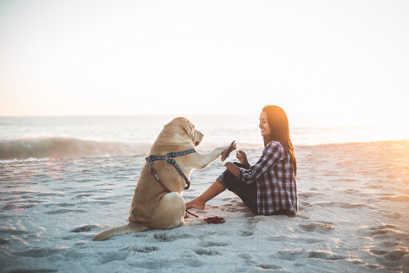

caption: a woman and her dog on the beach


In [13]:
def generate_caption(image_path, model):
  image_size = 384
  # image = load_demo_image_url(image_size=image_size, device=device)
  image = load_demo_image_path(image_path=image_path,image_size=image_size, device=device)

  with torch.no_grad():
      # beam search
      caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
      # nucleus sampling
      # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
      print('caption: '+caption[0])
      return caption[0]
description = generate_caption(image_path, model)

# Use Langchain generate background

In [14]:
from langchain.prompts import PromptTemplate
from langchain.llms import OpenAI
from langchain.chains import LLMChain


OPENAI_API_KEY = ""
llm = OpenAI(temperature=0.9,openai_api_key=OPENAI_API_KEY)
prompt = PromptTemplate(
    input_variables=["description"],
    template="What is top 10 background for {description}?",
)


chain = LLMChain(llm=llm, prompt=prompt)

# Run the chain only specifying the input variable.
print(chain.run(description))



1. Blue sky with puffy white clouds
2. Rolling waves on a golden sand beach
3. Sun setting over the horizon
4. Colorful beach umbrellas in the background
5. A flock of seagulls flying by
6. A colorful beach towel draped over the sand
7. Palm trees swaying in the breeze
8. Sun reflecting off the water’s surface
9. Puppy chasing the waves on the beach
10. Woman and her pup enjoying an evening walk on the beach
